In [30]:
## For debbugging
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# import os
import sys
from pathlib import Path
module_path = Path('.').resolve().parents[1]
if module_path not in sys.path:
    sys.path.append(str(module_path))


In [3]:
## for debugging:
# %aimport mlp.keyword
# %aimport mlp.tools
%aimport mlp.kex
%aimport app.test_app
%aimport mlp.tree
%aimport mlp.plot
%autoreload 1
from mlp.kex import *
from mlp.tree import node_adj_mat, tag_network, tag_df_network
from mlp.plot import hv_net
from bokeh.palettes import Viridis10, Category10_6
import networkx as nx

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
%matplotlib inline

In [5]:
%gui qt
import PyQt5.QtWidgets as qw
from app.test_app import MyWindow
from PyQt5 import QtCore



In [6]:
import dask.dataframe as dd
import dask
import string
from fuzzywuzzy import process as zz


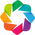

In [7]:
import holoviews as hv
hv.extension('bokeh')

%opts Graph [width=600 height=400]

In [8]:
data_dir = module_path/'data'/'gs_data'

df = dd.read_csv(data_dir/'gs_data.csv',
                 dtype={'Part in Process': 'object',
                        'Time Submitted': 'object',
                        'Time Up': 'object'})


gs_nlp_select = NLPSelect(columns = ['Description', 'Resolution'])

raw_text = gs_nlp_select.transform(df)

### Build Vocab 

In [9]:
tex = TokenExtractor()
toks = tex.fit_transform(raw_text)
print(tex.vocab_)

['replaced' 'broken' 'st' ... 'volts' 'surge' 'subsequently']


In [10]:
vocab_fname = data_dir/'vocab.csv'
# vocab_fname = data_dir/'mine_vocab_app.csv'

vocab = tex.annotation_assistant(vocab_fname)

attempting to initialize with pre-existing vocab
intialized successfully!
saved locally!


In [11]:
if __name__ == '__main__':

    app = QtCore.QCoreApplication.instance()
    if app is None:
        app = app = qw.QApplication(sys.argv)

    window = MyWindow(vocab_filename=vocab_fname)
    window.show()

    app.exec_()

In [12]:
vocab = tex.annotation_assistant(filename=vocab_fname)

attempting to initialize with pre-existing vocab
intialized successfully!
saved locally!


### Extract Keywords

In [13]:

# vocab = pd.read_csv(data_dir/'app_vocab_mike.csv', index_col=0)
# how many instances of each keyword class are there?
print('named entities: ')
print('I\tItem\nP\tProblem\nS\tSolution\nR\tRedundant')
print('U\tUnknown\nX\tStop Word')
print('total tokens: ', vocab.NE.notna().sum())
print('total tags: ', vocab.groupby("NE").nunique().alias.sum())
vocab.groupby("NE").nunique()

named entities: 
I	Item
P	Problem
S	Solution
R	Redundant
U	Unknown
X	Stop Word
total tokens:  670
total tags:  295


,NE,alias,notes,score
NE,,,,
I,1,146,7,353
P,1,26,0,77
S,1,29,0,105
U,1,90,5,129
X,1,4,0,4


In [14]:
tag_df = tags_to_df(tag_extractor(tex, raw_text, toks, vocab))

X token loop:   0%|          | 0/4 [00:00<?, ?it/s]
Category Loop: 6it [00:05,  1.16it/s]                       


In [16]:
# tag-complete work-orders?
wo_tot = len(df)
tag_comp = (tag_df['NA'].sum(axis=1)==0).sum()
print(f'Tag complete: {tag_comp}', f'\n{tag_comp/wo_tot:.2%}')


Tag complete: 3137 
91.24%


In [18]:
# tag-empty? 
tag_empt = ((tag_df['I'].sum(axis=1)==0)&(tag_df['P'].sum(axis=1)==0)&(tag_df['S'].sum(axis=1)==0)).sum()
print(f'Tag empty: {tag_empt}', f'\n{tag_empt/wo_tot:.2%}')

Tag empty: 15 
0.44%


## WORK BELOW HERE

In [19]:
tag_df
hori = df.MACH.compute().str.match(r'^[HI][0-9]*$').fillna(False)
isbroke = (tag_df.P.broken==1)
df.MACH.compute()[hori]



0       H27
1        H5
3       H18
4       H23
5       H24
6       H27
7       H33
8        H8
9        I2
10       I3
11       I5
13      H10
14      H20
15       I2
16       I6
18      H14
19       I1
20       I4
22      H10
23      H11
24       H3
25       H3
28      H14
29      H19
30       H8
31       I2
33      H14
34      H14
35      H29
36       H3
       ... 
3398    H15
3400    I17
3401    H29
3402    H26
3404    H10
3405    H32
3406    H27
3407    H32
3408    H10
3409    H34
3410    H22
3411    H32
3412     I5
3413     H5
3414     H5
3415    H10
3418    H12
3419    H22
3420     I1
3421    H25
3422     I6
3423    H29
3424     H8
3425    H10
3428     H4
3429    H25
3430    H37
3431    H10
3432     I3
3435    H31
Name: MACH, Length: 2401, dtype: object

In [31]:
df.compute()['Description'][df.compute()['Tech Full Name'].str.contains('Lyle Cookson').fillna(False)]

def person_tags(name, n_reps):
    isguy = df.compute()['Tech Full Name'].str.contains(name).fillna(False)
    return tag_df.loc[isguy,(tag_df.loc[isguy,:].sum()>n_reps).values]

lyle_tags, steve_tags, andrew_tags = (person_tags('Lyle Cookson', 1),
                                      person_tags('Steve Andreozzi', 20),
                                      person_tags('Anthony Paolillo', 10))

# islyle = df.compute()['Tech Full Name'].str.contains('Lyle Cookson').fillna(False)
# lyle_tags = tag_df.loc[islyle,(tag_df.loc[islyle,:].sum()>1).values]#.sum().sort_values(ascending=False).

# issteve = df.compute()['Tech Full Name'].str.contains('Steve Andreozzi').fillna(False)
# steve_tags = tag_df.loc[issteve,(tag_df.loc[issteve,:].sum()>20).values]
# # lyle_tags.columns = lyle_tags.columns.droplevel(0)

# issteve = df.compute()['Tech Full Name'].str.contains('Steve Andreozzi').fillna(False)
# steve_tags = tag_df.loc[issteve,(tag_df.loc[issteve,:].sum()>20).values]



Glyle, *_ = tag_df_network(lyle_tags)
Gsteve, *_ = tag_df_network(steve_tags)
Gandrew, *_ = tag_df_network(andrew_tags)
# nx.draw_networkx(G, edge_color='y',
#                  pos=nx.spring_layout(G, weight='weight'));
# nx.layout.

In [32]:
%%opts Graph (edge_line_alpha=.1 edge_line_width=4 node_line_color='white')
%%opts Overlay [width=200 legend_position='top_left'] 
%%opts Graph [tools=['hover'], color_index='NE'] (cmap=Category10_6) 
%%opts Graph (node_size='size')
padding = dict(x=(-0.05, 1.05), y=(-0.05, 1.05))
# colors = ['#000000']+hv.Cycle('Category20').values

lyle_graph = hv_net(lyle_tags, name='Lyle')
lyle_graph = lyle_graph.redim.range(**padding)

steve_graph = hv_net(steve_tags, name='Steve')
steve_graph = steve_graph.redim.range(**padding)

andrew_graph = hv_net(andrew_tags, name='Andrew')
andrew_graph = andrew_graph.redim.range(**padding)
# graph.edgepaths.sample(weight>0)
hv.Layout(steve_graph + lyle_graph + andrew_graph).cols(1)
# graph.edgepaths*graph.nodes

:Layout
   .Graph.Steve  :Graph   [source,target]   (weight)
   .Graph.Lyle   :Graph   [source,target]   (weight)
   .Graph.Andrew :Graph   [source,target]   (weight)

In [291]:
from holoviews.operation.datashader import datashade, bundle_graph
bundled = bundle_graph(graph)
bundled

ImportError: cannot import name 'XArrayInterface'

Index(['chain', 'bar', 'accumulator'], dtype='object')


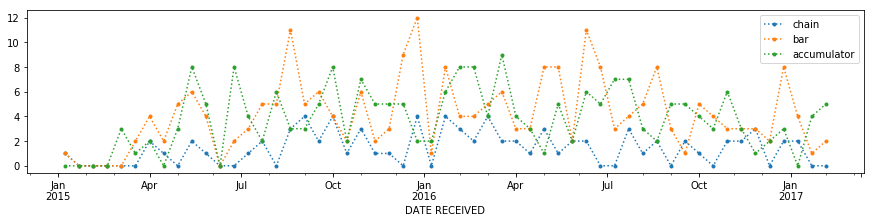

In [34]:
# wo_num = 0
# sample_tag = tag_df.loc[:,tag_df.loc[wo_num].astype(bool)]

sample_tag = tag_df[['chain', 'bar', 'accumulator']]
sample_tag = sample_tag.set_index(pd.DatetimeIndex(df['DATE RECEIVED'].compute()))
# .rolling(1000).sum()
# plt.figure()
sample_tag.resample('2W').sum().plot(figsize=(15,3), marker='.', ls=':')
# df.resample()
print(sample_tag.columns)

### 2-grams

In [33]:
thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
rx = re.compile(r'\b(' + '|'.join(map(re.escape, substr))+ r')\b')
clean_text = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)])
clean_text.compute()[:4]
# TfidfVectorizer()
# '(?u)\\b\\w\\w+\\b'

0     replace lubricant tank fill hose 
1         checked rotary head alignment
2       reweld shock sub to rotary head
3    centre tank not filling with water
dtype: object

In [34]:
from itertools import combinations, permutations, product
tex2 = TokenExtractor(ngram_range = (2,2))
#                       vocabulary=[' '.join(i) for i in combinations(vocab[vocab.alias.notna()].alias.unique(), 2)])
toks2 = tex2.fit_transform(clean_text)
print(tex2.vocab_)
voc2 = tex2.annotation_assistant(data_dir/'2g_mine_vocab_test.csv')

['lubricant service' 'oil leak' 'pm lubricant' ... 'station check'
 'check 24wk' 'fitter hydraulic']
New Vocab. file written to /home/tbsexton/Documents/Projects/DiagnosticKB/MaintenanceLanguageProcessing/data/mine_data/2g_mine_vocab_test.csv


SystemExit: 0

/home/tbsexton/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [35]:
NE_dict = vocab.NE.fillna('U').to_dict()
NE_dict.update(vocab.fillna('U').reset_index()[['NE', 'alias']].drop_duplicates().set_index('alias').NE.to_dict())
NE_sub = sorted(NE_dict, key=len, reverse=True)

# matcher = lambda s: r'\b'+re.escape(s)+r'\b'
# matcher = lambda s: re.escape(s)
NErx = re.compile(r'\b(' + '|'.join(map(re.escape, NE_sub))+ r')\b')
NE_text = voc2.index.str.replace(NErx, lambda match: NE_dict[match.group(0)])
voc2.loc[:,'NE'] = NE_text.tolist()



# g = vocab.groupby('alias')
# for one_grams in voc2.index.str.split().tolist():
#     for one_gram in one_grams:
#         try:
#             print(g.get_group(one_gram).NE[0])
#         except KeyError:
#             pass

TypeError: object of type 'float' has no len()

In [147]:
NE_map = {' '.join(i):'' for i in product('IPSUX', repeat=2)}

NE_map['I I'] = 'I'
NE_map['S I'] = 'S I'
NE_map['P I'] = 'P I'

NE_map['I S'] = 'S I'
NE_map['I P'] = 'P I'

NE_map['S S'] = 'X'
NE_map['P P'] = 'X'
NE_map['S P'] = 'X'
NE_map['P S'] = 'X'
# NE_map['']
voc2['NE'] = voc2.NE.apply(lambda x: NE_map[x])
# voc2_est.to_csv('test_estimated_2g.csv')
# voc2_est[(voc2_est!='') & (voc2_est!='X')]
voc2['score'] = tex2.scores_
# voc2.NE

# OLD

In [138]:
# tqdm.pandas(desc="KEx")
from sklearn.feature_extraction import stop_words
 
# print(stop_words.ENGLISH_STOP_WORDS)

thes_dict = vocab[vocab.alias.notna()].alias.to_dict()
substr = sorted(thes_dict, key=len, reverse=True)
rx = re.compile('|'.join(map(re.escape, substr)))

toks = raw_text.str.split()
toks = toks.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=toks)

tags = raw_text.str.replace(rx, lambda match: thes_dict[match.group(0)]).str.split()
tags = tags.apply(lambda d: d if isinstance(d, list) else [], 
                             meta=tags)

grps = vocab.groupby('NE')

# have to pre-allocate column names...dask doesn't like loops :(
tagI = tags.apply(lambda x: list(set(grps.get_group('I')['alias'].astype(str).tolist()) & set(x)),
                  meta=('I', object)).str.join(', ')
tagP = tags.apply(lambda x: list(set(grps.get_group('P')['alias'].astype(str).tolist()) & set(x)),
                  meta=('P', object)).str.join(', ')
tagS = tags.apply(lambda x: list(set(grps.get_group('S')['alias'].astype(str).tolist()) & set(x)),
                  meta=('S', object)).str.join(', ')

tagU = toks.apply(lambda x: list(set(x) - set(vocab.index) - set(stop_words.ENGLISH_STOP_WORDS)),
                  meta=('U', object)).str.join(', ')

ndf = dd.concat([ tagI, tagP, tagS, tagU], axis=1)


/home/tbsexton/anaconda3/lib/python3.6/site-packages/dask/dataframe/multi.py:571: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indexes of each dataframes are 
aligned. This assumption is not generally safe.
  warn("Concatenating dataframes with unknown divisions.\n"


In [139]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, CacheProfiler, visualize
from dask.distributed import Client
import dask

## multiproc, not thread, due to GIL with text. 
with Profiler() as prof, ResourceProfiler(dt=0.25) as rprof, CacheProfiler() as cprof:
    with ProgressBar(), dask.set_options(get=dask.multiprocessing.get):
        tag_df=ndf.compute()

# visualize([prof, rprof, cprof])
tag_df.head()

[########################################] | 100% Completed |  3.5s


,I,P,S,U
0,"chain, feeder",broken,repair,
1,"machine, cable, pendant, pin",short,replace,
2,part,broken,"order, repair",
3,accumulator,,"ok, charge, check",
4,"attachment, saw, hydraulic",leak,replace,


In [140]:
tag_df['og'] = raw_text
tag_df

,I,P,S,U,og
0,"chain, feeder",broken,repair,,broken bar feeder chain repaired
1,"machine, cable, pendant, pin",short,replace,,no power replaced pin in pendant and powered m...
2,part,broken,"order, repair",,smartscope harness broken parts ordered tech...
3,accumulator,,"ok, charge, check",,check charge accumulators where ok
4,"attachment, saw, hydraulic",leak,replace,,hyd leak at saw atachment replaced seal in saw...
5,"unit, thread",,"setup, complete",,cs1008 setup change over from arc1004 comple...
6,"saw, gear, shelf, attachment, person, unit",,"remove, replace, rebuild",,gears on saw attachment tight and grinding per...
7,accumulator,,"charge, check",,check and charge accumulators checked and charged
8,"mill, spindle, station",,repair,,st 14 milling spindle repairs reapired
9,"line, hydraulic","rupture, leak",replace,b,hydraulic leak replaced ruptured hydraulic lin...


In [16]:
# nlp_cols = ['Description', 'Resolution']
# nlp_cols=0
# raw_text = df.iloc[:,nlp_cols].fillna('').add(' ').sum(axis=1).str[:-1]

# raw_text = raw_text.str.lower()
# raw_text.str.replace('\n', ' ')
# raw_text = raw_text.str.replace('[{}]'.format(string.punctuation), ' ')

def series_itervals(s):
    for n, val in s.iteritems():
        yield val
# raw_text.compute()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

# vec = TfidfVectorizer(input='content', 
#                       ngram_range=(1,1),
#                       stop_words='english',
# #                       min_df=2, 
# #                       max_df=0.95,
#                       sublinear_tf=True,
#                       smooth_idf=False,
# #                       max_features=3000
#                      )

# tf = vec.fit(tqdm(series_itervals(raw_text)))


In [18]:
# tf = vec.transform(series_itervals(raw_text))  # CSR sparse array
# tf = tf.toarray()
tf.shape

(696211, 29422)

[('replace', 28671.656586049528),
 ('repair', 23315.672519843509),
 ('service', 18459.533601779585),
 ('oil', 12036.019749034887),
 ('leak', 11195.783407141291),
 ('inspection', 10932.103424049106),
 ('lube', 10514.25589025008),
 ('change', 10369.942455284563),
 ('air', 10333.877317125754),
 ('mechanical', 9512.6087999818319),
 ('engine', 9100.656635962685),
 ('lubrication', 9045.2935483057063),
 ('pm', 9004.4377757877755),
 ('hose', 8688.7022881740795),
 ('pump', 7257.4747167787609),
 ('brake', 7202.1964601366071),
 ('weekly', 7112.7785995961667),
 ('working', 7085.7028709121887),
 ('fault', 6908.7969158723181),
 ('repairs', 6648.2767971289823),
 ('check', 6523.6572009770825),
 ('lights', 6275.9485485594041),
 ('leaking', 6042.0799142608612),
 ('broken', 5316.8478967504361),
 ('start', 5230.6273081447243),
 ('hyd', 5222.4485127463586),
 ('light', 5192.9811273116611),
 ('inspections', 5050.1307590726065),
 ('pos', 4817.8297036323047),
 ('grease', 4804.9494999201734),
 ('changeout', 477

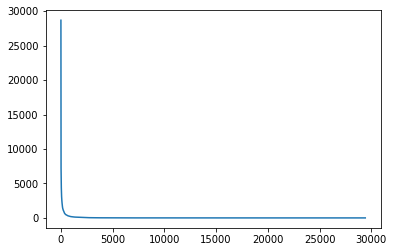

In [24]:
# sort = vec.idf_.argsort()
tf_tot = np.array(tf.sum(axis=0))[0]
sort = tf_tot.argsort()[::-1]

# np.array(vec.get_feature_names())[sort]
plt.plot(tf_tot[sort])
list(zip(np.array(vec.get_feature_names())[sort], tf_tot[sort]))


In [16]:
from numba import jit
import scipy.constants as cnst

# http://cse.iitkgp.ac.in/~pabitra/paper/stemmer.pdf
# @jit
# np.not_equal()

def str_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    return ser.sum()

def roll_D1(str1,str2, reg=None):
    if reg is None:
        reg = cnst.golden**(-np.arange(str1.shape[0]))
    ser = np.char.not_equal(str1,str2)*reg    
    
    left=np.roll(str1,1)
    ser_left = np.char.not_equal(left[1:], str2[:-1])*reg[1:]
    right = np.roll(str1,-1)
    ser_right = np.char.not_equal(left[:-1], str2[1:])*reg[1:]
    
    return ser.sum()*(ser_right.sum()+ser_left.sum())

In [17]:
first_zero = lambda l: next((i for i, x in enumerate(l) if x), None) # x!= 0 for strict match

def str_D2(str1,str2):
    lgth = max(len(str1[0]), len(str2[0]))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return geo_sum/m 
    else:
        return 100.

def str_D3(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    if (m is not None) and m>0:
        geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
        return (lgth-m)*geo_sum/m 
    else:
        return 100.
    
def str_D4(str1,str2):
    lgth = max(len(str1), len(str2))
#     print(lgth)
    a = str1[0].ljust(lgth)
    b = str2[0].ljust(lgth)
    
    ser = [int(i!=j) for i,j in zip(a,b)]
    m = first_zero(ser)
    geo_sum = (1-0.5**(lgth-m+1))/(1-0.5)  # \sum_{i=m}^n 1/2^{i-m}
    return (lgth-m)*geo_sum/lgth 
    
pd.to_    

In [21]:
strs = np.array(vec.get_feature_names())[sort]
# chars = np.zeros((len(strs), max(len(i) for i in strs)), dtype='unicode_')
# for n,i in enumerate(strs):
#     chars[n, :len(i)] = list(i)
# chars.shape

In [23]:
# http://scikit-learn.org/stable/faq.html#how-do-i-deal-with-string-data-or-trees-graphs
from fuzzywuzzy import process, fuzz
process.extractBests('replace', strs, limit=20, score_cutoff=75)
# process.extract()
# fuzz.WRatio()

# X = np.arange(chars.shape[0]).reshape(-1, 1)  # index look-up
# def str_dist(x,y, reg=None):
#     i,j = int(x[0]), int(y[0])  # extract indices
#     return str_D1(chars[i], chars[j], reg=reg)

[('replace', 100),
 ('replaced', 93),
 ('replacer', 93),
 ('replacel', 93),
 ('rreplace', 93),
 ('replaces', 93),
 ('repalace', 93),
 ('repplace', 93),
 ('rerplace', 93),
 ('reaplace', 93),
 ('1replace', 93),
 ('treplace', 93),
 ('replkace', 93),
 ('reeplace', 93),
 ('replacet', 93),
 ('replaace', 93),
 ('replace5', 93),
 ('replace4', 93),
 ('replacew', 93),
 ('replace3', 93)]

In [163]:
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric=str_dist, eps=.25, n_jobs=-1).fit(X)

grps = pd.DataFrame(index=strs,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

## Deprecated

In [146]:
from scipy.spatial import distance

# reg=cnst.golden**(-np.arange(X.shape[1]))
# %lprun -f str_D1 distance.pdist(X[:100], str_D1)
distance.squareform(distance.pdist(X[:100], str_D1))

array([[ 0.        ,  0.52786405,  1.76393202, ...,  2.52786405,
         2.52786405,  2.52786405],
       [ 0.52786405,  0.        ,  1.76393202, ...,  2.47213595,
         2.52786405,  2.47213595],
       [ 1.76393202,  1.76393202,  0.        , ...,  2.52786405,
         2.52786405,  2.52786405],
       ..., 
       [ 2.52786405,  2.47213595,  2.52786405, ...,  0.        ,
         2.52786405,  2.47213595],
       [ 2.52786405,  2.52786405,  2.52786405, ...,  2.52786405,
         0.        ,  2.29179607],
       [ 2.52786405,  2.47213595,  2.52786405, ...,  2.47213595,
         2.29179607,  0.        ]])

In [147]:


# sns.clustermap(distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), str_D1)),
#                yticklabels=strs, figsize=(15,20))
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(X, str_D1)), 
             index=strs, columns = strs)

/home/tbsexton/anaconda3/lib/python3.6/site-packages/seaborn/matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


accumulator     0.000000
accumulators    0.005025
accrepair       0.604878
access          0.604878
acc             0.604878
accessory       0.604878
accident        0.604878
actuator        0.750776
ac              0.986844
acond           0.986844
Name: accumulator, dtype: float64

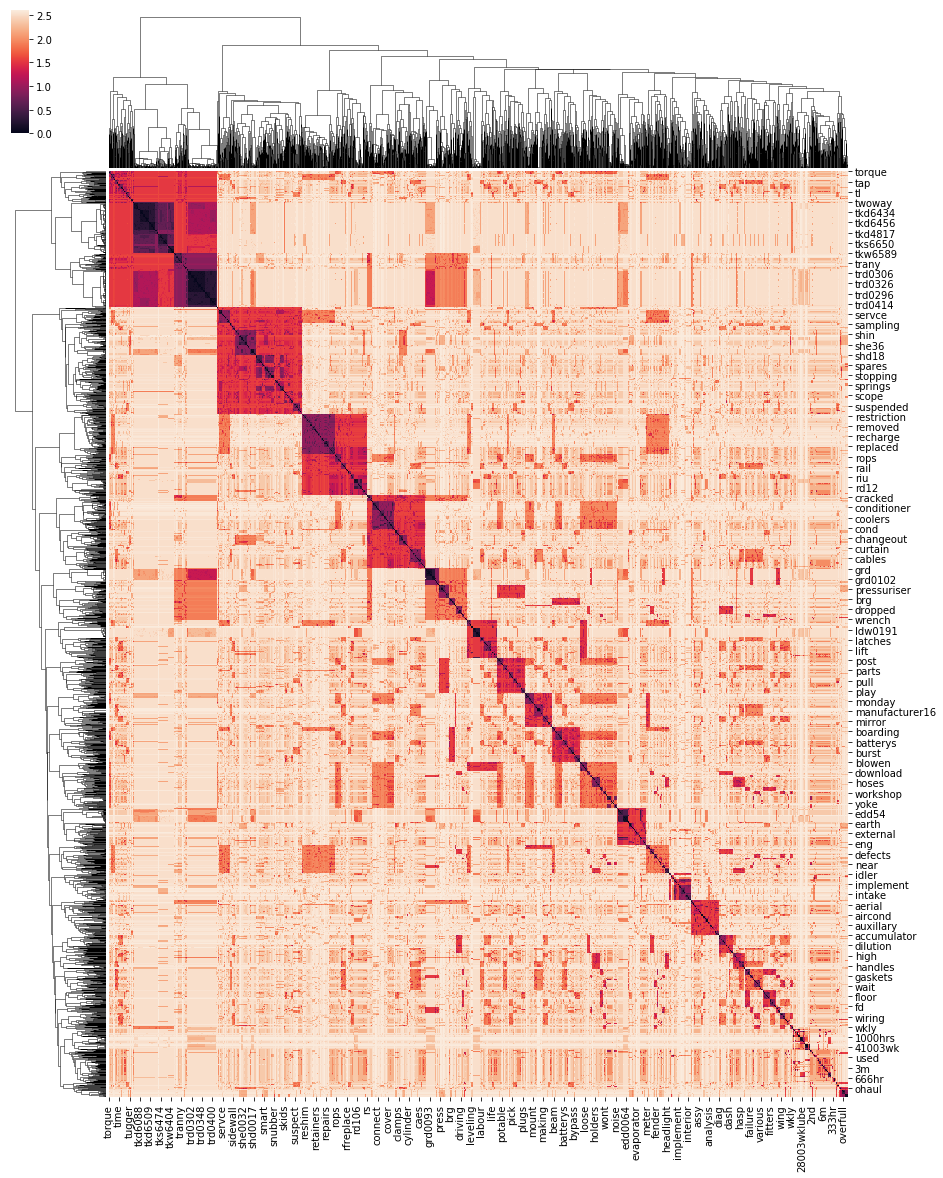

In [148]:
sns.clustermap(dist_mat,
               figsize=(15,20))

dist_mat['accumulator'].sort_values()[:10]

In [150]:
import pprint
from sklearn.cluster import DBSCAN
clust = DBSCAN(metric='precomputed', eps=.25).fit(dist_mat)

grps = pd.DataFrame(index=dist_mat.index,data=dict(cls=clust.labels_, score=tf_tot[sort][:2000]))
g = grps[grps.cls!=-1].groupby('cls')

grps['score_best'] = grps['score']
grps.loc[grps.cls!=-1,'score_best'] = g['score'].transform(max)
grps.sort_values(['score_best', 'score'], ascending=False).to_csv('clust_vocab_mine.csv', sep='\t')

In [218]:
from nltk.metrics.distance import edit_distance
# metrics.distance.edit_distance('abcde','abcfg')
ed_func = lambda x,y: edit_distance(x[0], y[0])
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(np.array(strs).reshape(-1,1), 
                                                                ed_func)), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.0
contactor      7.0
motor          7.0
completed      7.0
operator       7.0
conveyor       8.0
clamp          8.0
coolant        8.0
filter         8.0
rebuilt        8.0
Name: accumulator, dtype: float64

In [230]:
vec_mat = vec.transform(series_itervals(raw_text)).toarray().T
dist_mat = pd.DataFrame(data=distance.squareform(distance.pdist(vec_mat,'cosine')), 
             index=strs, columns = strs)
dist_mat['accumulator'].sort_values()[:10]

accumulator    0.000000
check          0.322233
30bar          0.376422
charged        0.413130
requested      0.529558
charge         0.685735
lp             0.701154
25bar          0.723847
tag            0.729880
ok             0.746831
Name: accumulator, dtype: float64

In [11]:
for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)

E:\Thurston\Documents\Code\Pycharm\ml-py\data\gs_data\TEMP_init-0.txt


In [129]:
# docs = textacy.fileio.read.read_csv(str(data_dir/'TEMP_init-0.txt'))
# Descriptions in RawText col
# content_stream, metadata_stream = textacy.fileio.split_record_fields(docs, 1)  

corpus = textacy.Corpus(u'en')

for fname in data_dir.glob('TEMP_init-*.txt'):
    print(fname)
    docs = textacy.fileio.read.read_csv(str(fname), delimiter='\t')
    content_stream, _ = textacy.fileio.split_record_fields(docs, 0)  
    corpus.add_texts(content_stream)

/home/tbsexton/Documents/Projects/DiagnosticKB/MaintenanceLanguageProcessing/data/gs_data/TEMP_init-0.txt


In [144]:
vsm = textacy.vsm.Vectorizer(weighting='tfidf',
                             normalize=False,
                             smooth_idf=False,
                             sublinear_tf=True,
                             min_df=2, max_df=0.95)  # each token in >2 docs, <95% of docs

terms_list = (doc.to_terms_list(ngrams=(1, 2, 3),
                                normalize=u'lemma',
                                named_entities=False,
                                filter_stops=True,  # Nope! Not needed :)
                                filter_punct=True,
                                as_strings=True) for doc in corpus)
doc_term_mat = vsm.fit_transform(terms_list)
doc_term_mat

def get_norm_tokens(doc_n, doc_term_mat, id_to_term):
    doc = doc_term_mat[doc_n].toarray()
    # we only care about unique tags, right?
    return set([id_to_term[i] for i in doc.nonzero()[1]])

# list(list(terms_list)[1])

In [145]:
get_norm_tokens(0, doc_term_mat, vsm.id_to_term)

{'bar',
 'bar feeder',
 'bar feeder chain',
 'break',
 'break bar',
 'break bar feeder',
 'chain',
 'feeder',
 'feeder chain',
 'repair'}

In [ ]:
vsm.sublinear_tf()